# Bike-Share trip analysis

In this project we examine the last 12 month publicly available data on Divvy Bikeshare trips in Chicago. The business question we have in mind is what are the main differences of how the casual users use Divvy bike compared to paying members. After this analysis we intend to produce business recommendations aimed at converting casual users to paying subscribers. 

The data is available publicly at: https://divvy-tripdata.s3.amazonaws.com/index.html

It has some major limitations: there is no way to group the trips by user, since the data is completely anonimized. There is also no demographic data, which would have allowed us to see if the trip-taker lives in the area or is visiting short term. 

In [1]:
import os
import pandas as pd
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.io.img_tiles import OSM
from sklearn.cluster import KMeans,OPTICS
import csv
import zipfile
import numpy as np
import glob
import pickle
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import ttest_ind


extract_path='data/'
zip_dir='data/originals/'   



## Data Preparation and Cleaning
Files are extracted for .zip files in data/originals folder, then processed, and combined into a single master .csv file, which is then split into members and casual users data.

### Cleaning 
Time columns are converted to pandas datetime datatype.

    to-do:
    identify cases where start date is after end date and remove those cases
    identify cases where the ride duration is >1 day. these cases a likely incorrectly logged or are extreme outliers, so remove them
    remove "instant trips" (<30 seconds), these seem to be mistaken unlocks where bikes are returned immediately


### Processing
- The original data comes with GPS coordinates of start and end of each trip. For our basic analysis we make use of these by using them to calculate the trip distance. After the calculation the coordinate columns are dropped.
- Ride length is calculated as timedelta
- Day of the week is determined from the start date
- Speed is calculated from the distance and trip duration

    to-do:
    make a time-of-day distribution

In [2]:
# This function calculates the distance between two geographical points using haversine formula
def calc_distance(start_lat,start_lng,end_lat,end_lng):
    start=(start_lat,start_lng)
    end=(end_lat,end_lng)
    dist=haversine(start,end,unit=Unit.MILES)
    return dist

def process(df):
    #print (df.columns)
    df['started_at']=pd.to_datetime(df['started_at'])
    df['ended_at']=pd.to_datetime(df['ended_at'])
    df['member_casual']=df['member_casual'].astype('category')
    df['rideable_type']=df['rideable_type'].astype('category')
    df['ride_length']=abs(df['ended_at']-df['started_at'])
    #print (df['ride_length'].dtype)
    df['day_of_week']=df['started_at'].dt.dayofweek
    df['distance']=df.apply(lambda row: calc_distance(row["start_lat"], row["start_lng"], row["end_lat"], row["end_lng"]), axis=1)
    df['distance']=df['distance'].round(2)
    df['speed']=df['distance']/df['ride_length'].dt.total_seconds()*3600
    df['speed']=df['speed'].round(2)
    df['speed']=df['speed'].replace(np.inf,np.nan)
    df=df.drop(columns=['start_lat','start_lng','end_lat','end_lng'])
    return df





In [3]:
if not os.path.exists('combined.pkl'):
    for zip_filename in os.listdir(zip_dir):
        if zip_filename.endswith('.zip'):
            with zipfile.ZipFile(os.path.join(zip_dir,zip_filename),'r') as zip_file:
                zip_file.extractall(extract_path)
    for filename in os.listdir(extract_path):
        if filename.endswith('.csv') and not os.path.exists(extract_path+'/processed/'+filename+'_processed.csv'):
            chunks=pd.read_csv(os.path.join(extract_path,filename),chunksize=1000)
            df=pd.concat(chunks,ignore_index=True)
            df.to_csv(extract_path+'/processed/'+filename+'_processed.csv')
    path=extract_path+'/processed/*.csv'
    csv_files=glob.glob(path)
    print(csv_files)
    dfs=[]
    for file in csv_files:
        df=pd.read_csv(file)
        print('reading ',file)
        df=process(df)
        df=df.drop(df.columns[0],axis=1)
        #print(df.columns)
        dfs.append(df)
    combined_df=pd.concat(dfs,ignore_index=True)
    combined_df.to_pickle('combined.pkl')
    #combined_df.to_csv('combined.csv', index=False)
combined_df=pd.read_pickle('combined.pkl')

['data//processed\\202111-divvy-tripdata.csv_processed.csv', 'data//processed\\202112-divvy-tripdata.csv_processed.csv', 'data//processed\\202201-divvy-tripdata.csv_processed.csv', 'data//processed\\202202-divvy-tripdata.csv_processed.csv', 'data//processed\\202203-divvy-tripdata.csv_processed.csv', 'data//processed\\202204-divvy-tripdata.csv_processed.csv', 'data//processed\\202205-divvy-tripdata.csv_processed.csv', 'data//processed\\202206-divvy-tripdata.csv_processed.csv', 'data//processed\\202207-divvy-tripdata.csv_processed.csv', 'data//processed\\202208-divvy-tripdata.csv_processed.csv', 'data//processed\\202209-divvy-publictripdata.csv_processed.csv', 'data//processed\\202210-divvy-tripdata.csv_processed.csv']
reading  data//processed\202111-divvy-tripdata.csv_processed.csv
reading  data//processed\202112-divvy-tripdata.csv_processed.csv
reading  data//processed\202201-divvy-tripdata.csv_processed.csv
reading  data//processed\202202-divvy-tripdata.csv_processed.csv
reading  data

In [4]:
print(combined_df.head())
print(combined_df.dtypes)

            ride_id  rideable_type          started_at            ended_at  \
0  7C00A93E10556E47  electric_bike 2021-11-27 13:27:38 2021-11-27 13:46:38   
1  90854840DFD508BA  electric_bike 2021-11-27 13:38:25 2021-11-27 13:56:10   
2  0A7D10CDD144061C  electric_bike 2021-11-26 22:03:34 2021-11-26 22:05:56   
3  2F3BE33085BCFF02  electric_bike 2021-11-27 09:56:49 2021-11-27 10:01:50   
4  D67B4781A19928D4  electric_bike 2021-11-26 19:09:28 2021-11-26 19:30:41   

  start_station_name start_station_id end_station_name end_station_id  \
0                NaN              NaN              NaN            NaN   
1                NaN              NaN              NaN            NaN   
2                NaN              NaN              NaN            NaN   
3                NaN              NaN              NaN            NaN   
4                NaN              NaN              NaN            NaN   

  member_casual     ride_length  day_of_week  distance  speed  
0        casual 0 days 00:19

In [5]:
combined_df['rideable_type']=combined_df['rideable_type'].astype('category')

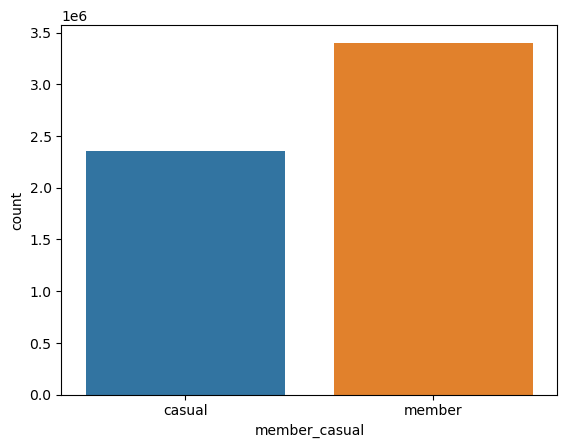

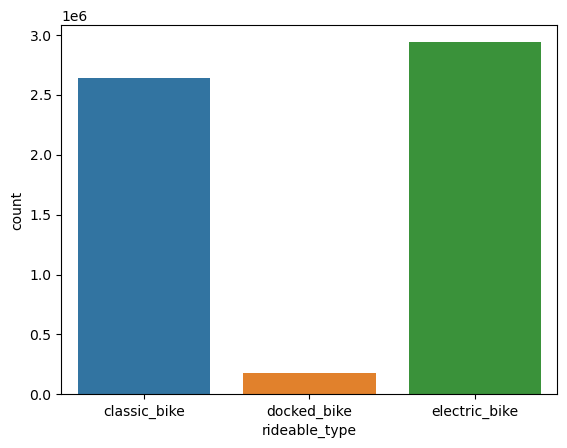

In [6]:
#combined_df['member_casual'].value_counts().plot(kind='bar')
sns.countplot(data=combined_df, x='member_casual')
plt.show()
sns.countplot(data=combined_df, x='rideable_type')
plt.show()

## Analysis

Working with Members and Casual riders data separately we perform the following calculations:

- Count total trips
- Calculate mean distance(miles) and duration(minutes)
- Calculate proportion of electric bike users
- Create distributions of bike usage by day of the week
- Create distributions of bike usage by month

In [7]:
df_members=combined_df[combined_df['member_casual']=='member']
#df_members=pd.read_csv('members.csv')

#df_members['started_at'] = pd.to_datetime(df_members['started_at'], errors='coerce')
#df_members['ended_at'] = pd.to_datetime(df_members['ended_at'], errors='coerce')
#df_members['ride_length'] = pd.to_timedelta(df_members['ride_length'], errors='coerce')

num_trips_members=df_members['ride_id'].count()
avg_distance_members=df_members['distance'].mean()
avg_ride_length_members=df_members['ride_length'].mean()
members_duration_dist=df_members['ride_length'].dt.total_seconds()/60
members_distance_dist=df_members['distance']

electric_members=len(df_members[df_members['rideable_type']=='electric_bike'])
electric_members_proportion=electric_members/np.count_nonzero(df_members['rideable_type'])

#day of the week distribution
df_members.set_index('day_of_week',drop=False,inplace=True)
df_members_dayofweek_dist_series=df_members['day_of_week'].value_counts().sort_index()
#month distribution
df_members.set_index('started_at',drop=False,inplace=True)
df_members_month_dist_series=df_members.groupby(pd.Grouper(freq='M')).size()

#time of day distribution
df_members['started_at_time']=df_members['started_at'].dt.time
df_members['started_at_time']=pd.to_datetime(df_members['started_at_time'],format='%H:%M:%S', errors='coerce')
df_members.set_index('started_at_time',drop=False,inplace=True)
df_members_hour_dist_series=df_members.groupby(pd.Grouper(freq='30Min')).size()
df_members=df_members.reset_index(drop=True)


C:\Users\Moses\AppData\Local\Temp\ipykernel_1972\406626304.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_members['started_at_time']=df_members['started_at'].dt.time
C:\Users\Moses\AppData\Local\Temp\ipykernel_1972\406626304.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_members['started_at_time']=pd.to_datetime(df_members['started_at_time'],format='%H:%M:%S', errors='coerce')


In [8]:
df_members.dtypes

ride_id                        object
rideable_type                category
started_at             datetime64[ns]
ended_at               datetime64[ns]
start_station_name             object
start_station_id               object
end_station_name               object
end_station_id                 object
member_casual                category
ride_length           timedelta64[ns]
day_of_week                     int64
distance                      float64
speed                         float64
started_at_time        datetime64[ns]
dtype: object

In [9]:
#df_casuals=pd.read_csv('casuals.csv')
df_casuals=combined_df[combined_df['member_casual']=='casual']

#df_casuals['started_at'] = pd.to_datetime(df_casuals['started_at'], errors='coerce')
#df_casuals['ended_at'] = pd.to_datetime(df_casuals['ended_at'], errors='coerce')
#df_casuals['ride_length'] = pd.to_timedelta(df_casuals['ride_length'], errors='coerce')

num_trips_casuals=df_casuals['ride_id'].count()
avg_distance_casuals=df_casuals['distance'].mean()
avg_ride_length_casuals=df_casuals['ride_length'].mean()

casuals_duration_dist=df_casuals['ride_length'].dt.total_seconds()/60
casuals_distance_dist=df_casuals['distance']

electric_casuals=len(df_casuals[df_casuals['rideable_type']=='electric_bike'])
electric_casuals_proportion=electric_casuals/np.count_nonzero(df_casuals['rideable_type'])

#day of the week distribution
df_casuals.set_index('day_of_week',drop=False,inplace=True)
df_casuals_dayofweek_dist_series=df_casuals['day_of_week'].value_counts().sort_index()

#month distribution
df_casuals.set_index('started_at',drop=False,inplace=True)
df_casuals_month_dist_series=df_casuals.groupby(pd.Grouper(freq='M')).size()

#time of day distribution
df_casuals['started_at_time']=df_casuals['started_at'].dt.time
df_casuals['started_at_time']=pd.to_datetime(df_casuals['started_at_time'],format='%H:%M:%S', errors='coerce')
df_casuals.set_index('started_at_time',drop=False,inplace=True)
df_casuals_hour_dist_series=df_casuals.groupby(pd.Grouper(freq='30Min')).size()
df_casuals=df_casuals.reset_index(drop=True)
#del df_casuals 

C:\Users\Moses\AppData\Local\Temp\ipykernel_1972\1592814421.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_casuals['started_at_time']=df_casuals['started_at'].dt.time
C:\Users\Moses\AppData\Local\Temp\ipykernel_1972\1592814421.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_casuals['started_at_time']=pd.to_datetime(df_casuals['started_at_time'],format='%H:%M:%S', errors='coerce')


In [10]:
df_casuals.dtypes

ride_id                        object
rideable_type                category
started_at             datetime64[ns]
ended_at               datetime64[ns]
start_station_name             object
start_station_id               object
end_station_name               object
end_station_id                 object
member_casual                category
ride_length           timedelta64[ns]
day_of_week                     int64
distance                      float64
speed                         float64
started_at_time        datetime64[ns]
dtype: object

### Summary table

In [11]:
summary_columns=['user_type','number of trips','average trip distance(miles)','average trip duration(minutes)','electric bike proportion']
casuals_summary=['casual users',num_trips_casuals,avg_distance_casuals,avg_ride_length_casuals,electric_casuals_proportion]
members_summary=['members',num_trips_members,avg_distance_members,avg_ride_length_members,electric_members_proportion]
summary=[casuals_summary,members_summary]
summary_df=pd.DataFrame(summary,columns=summary_columns)
summary_df.round(2)

,user_type,number of trips,average trip distance(miles),average trip duration(minutes),electric bike proportion
0,casual users,2353033,1.36,0 days 00:29:10.313803078,0.54
1,members,3402661,1.30,0 days 00:12:43.076957416,0.49


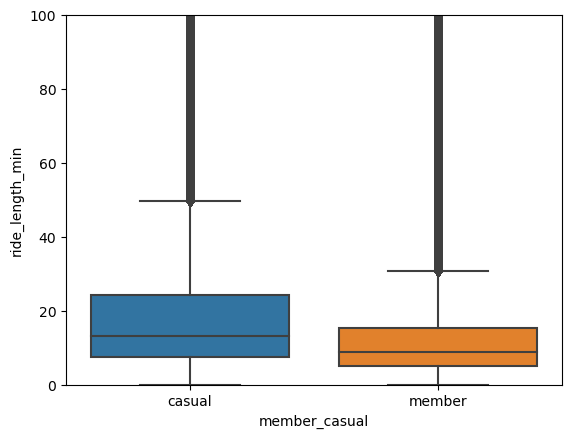

Mean casual user ride duration is 29.171896717981628 minutes
Mean member ride duration is 12.717949290276577 minutes
-111.14497976334872
0.0


In [12]:
combined_df['ride_length_min'] = combined_df['ride_length'].dt.total_seconds()/60
sns.boxplot(data=combined_df,x='member_casual',y='ride_length_min')
plt.ylim([0,100])
plt.show()
print('Mean casual user ride duration is {} minutes'.format(combined_df.query('member_casual=="casual"')['ride_length_min'].mean()))
print('Mean member ride duration is {} minutes'.format(combined_df.query('member_casual=="member"')['ride_length_min'].mean()))

statistic,p=ttest_ind(combined_df[combined_df['member_casual']=='member']['ride_length_min'].dropna(),
                     combined_df[combined_df['member_casual']=='casual']['ride_length_min'].dropna())


print (statistic)
print(p)

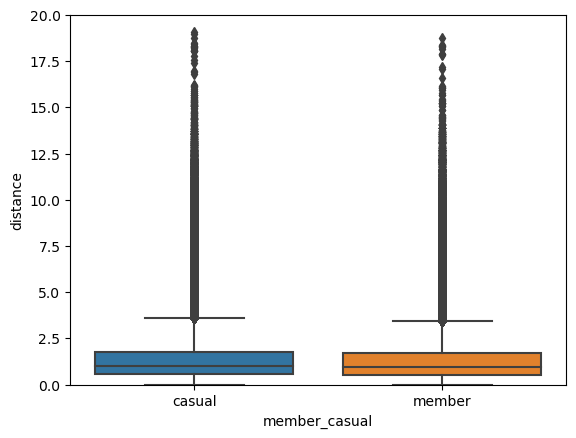

Mean casual user ride distance is 1.3585278435206976 miles
Mean member ride duration is 1.2975267506754053 miles
1.3585278435206976
1.2975267506754053
-58.00965518600374
0.0


In [13]:
#combined_df['ride_length_sec'] = combined_df['ride_length'].dt.total_seconds()/60
sns.boxplot(data=combined_df,x='member_casual',y='distance')
plt.ylim([0,20])
plt.show()
statistic,p=ttest_ind(combined_df[combined_df['member_casual']=='member']['distance'].dropna(),
                     combined_df[combined_df['member_casual']=='casual']['distance'].dropna())
print('Mean casual user ride distance is {} miles'.format(combined_df.query('member_casual=="casual"')['distance'].mean()))
print('Mean member ride duration is {} miles'.format(combined_df.query('member_casual=="member"')['distance'].mean()))


print(combined_df.query('member_casual=="casual"')['distance'].mean())
print(combined_df.query('member_casual=="member"')['distance'].mean())
print (statistic)
print(p)

[ 0.          0.40816327  0.81632653  1.2244898   1.63265306  2.04081633
  2.44897959  2.85714286  3.26530612  3.67346939  4.08163265  4.48979592
  4.89795918  5.30612245  5.71428571  6.12244898  6.53061224  6.93877551
  7.34693878  7.75510204  8.16326531  8.57142857  8.97959184  9.3877551
  9.79591837 10.20408163 10.6122449  11.02040816 11.42857143 11.83673469
 12.24489796 12.65306122 13.06122449 13.46938776 13.87755102 14.28571429
 14.69387755 15.10204082 15.51020408 15.91836735 16.32653061 16.73469388
 17.14285714 17.55102041 17.95918367 18.36734694 18.7755102  19.18367347
 19.59183673 20.        ]


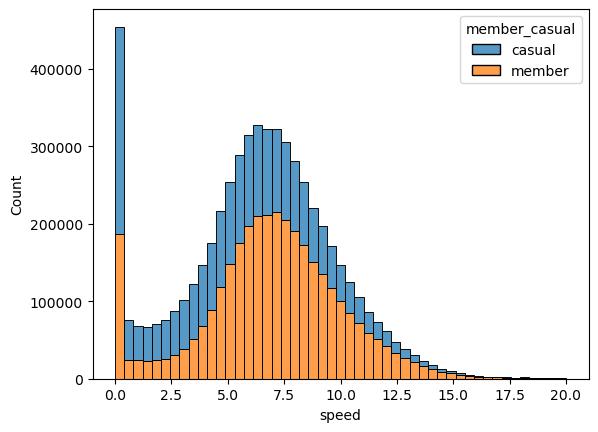

In [14]:
bins = np.linspace(0, 20, 50)
print (bins)
#sns.histplot(df_casuals['speed'],bins=bins,color='blue')
#sns.histplot(df_members['speed'],bins=bins,color='red')
sns.histplot(data=combined_df,x='speed',hue='member_casual',multiple='stack',bins=bins)
plt.show()

[0.         0.16326531 0.32653061 0.48979592 0.65306122 0.81632653
 0.97959184 1.14285714 1.30612245 1.46938776 1.63265306 1.79591837
 1.95918367 2.12244898 2.28571429 2.44897959 2.6122449  2.7755102
 2.93877551 3.10204082 3.26530612 3.42857143 3.59183673 3.75510204
 3.91836735 4.08163265 4.24489796 4.40816327 4.57142857 4.73469388
 4.89795918 5.06122449 5.2244898  5.3877551  5.55102041 5.71428571
 5.87755102 6.04081633 6.20408163 6.36734694 6.53061224 6.69387755
 6.85714286 7.02040816 7.18367347 7.34693878 7.51020408 7.67346939
 7.83673469 8.        ]


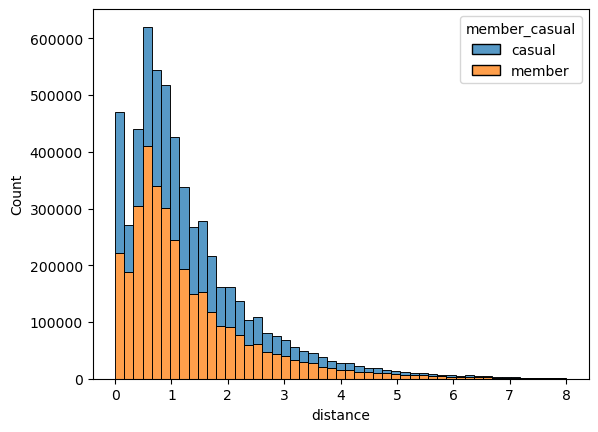

In [15]:
bins = np.linspace(0, 8, 50)
print (bins)
#sns.histplot(df_casuals['speed'],bins=bins,color='blue')
#sns.histplot(df_members['speed'],bins=bins,color='red')
sns.histplot(data=combined_df,x='distance',hue='member_casual',multiple='stack',bins=bins)
plt.show()

<AxesSubplot:xlabel='speed', ylabel='Count'>

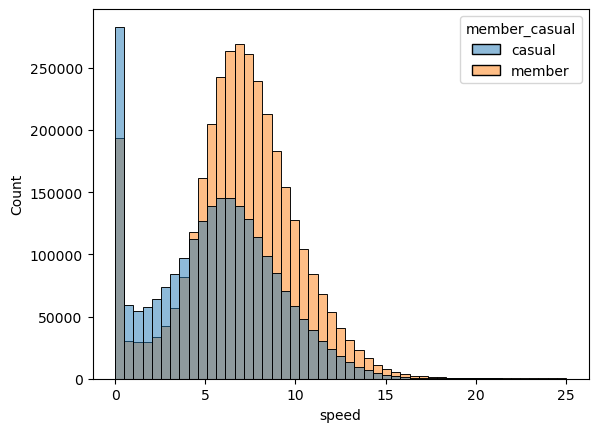

In [16]:
bins = np.linspace(0, 25, 50)
sns.histplot(data=combined_df,x='speed',bins=bins, hue='member_casual')

In [17]:
combined_df['speed'].describe()

count    5.749405e+06
mean     6.615372e+00
std      1.229537e+01
min      0.000000e+00
25%      4.470000e+00
50%      6.570000e+00
75%      8.540000e+00
max      1.716712e+04
Name: speed, dtype: float64

In [18]:
statistic,p=ttest_ind(combined_df[combined_df['member_casual']=='member']['speed'].dropna(),
                     combined_df[combined_df['member_casual']=='casual']['speed'].dropna())
print(statistic,p)
print('Mean casual user ride speed is {} mph'.format(combined_df.query('member_casual=="casual"')['speed'].mean()))
print('Mean member ride speed is {} mph'.format(combined_df.query('member_casual=="member"')['speed'].mean()))



130.22273470622972 0.0
Mean casual user ride speed is 5.812752576387222 mph
Mean member ride speed is 7.169289830877985 mph


### Bike usage by day of the week

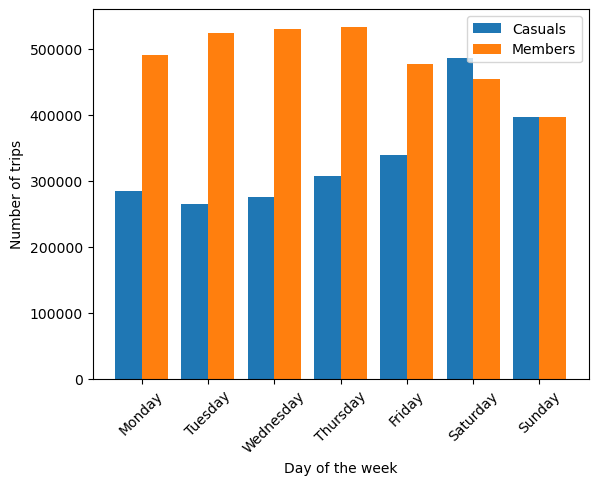

In [19]:
X = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, df_casuals_dayofweek_dist_series, 0.4, label = 'Casuals')
plt.bar(X_axis + 0.2, df_members_dayofweek_dist_series, 0.4, label = 'Members')
#plt.bar(X_axis - 0.2, casuals_days_of_week_dist/np.sum(casuals_days_of_week_dist), 0.4, label = 'Casuals')
#plt.bar(X_axis + 0.2, members_days_of_week_dist/np.sum(members_days_of_week_dist), 0.4, label = 'Members')
plt.xticks(X_axis, X,rotation = 45)
plt.xlabel("Day of the week")
plt.ylabel("Number of trips")
#plt.title("Number of tri in each group")
plt.legend()
plt.show()

### Bike usage by month

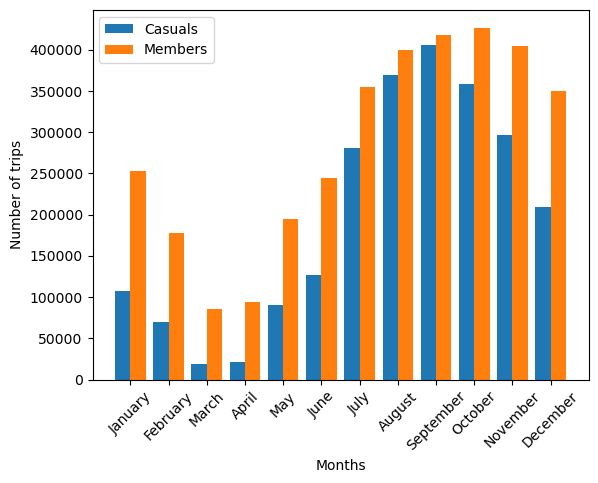

In [20]:
X = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, df_casuals_month_dist_series, 0.4, label = 'Casuals')
plt.bar(X_axis + 0.2, df_members_month_dist_series, 0.4, label = 'Members')
#plt.bar(X_axis - 0.2, casuals_month_dist/np.sum(casuals_month_dist), 0.4, label = 'Casuals')
#plt.bar(X_axis + 0.2, members_month_dist/np.sum(members_month_dist), 0.4, label = 'Members')

plt.xticks(X_axis, X, rotation=45)
plt.xlabel("Months")
plt.ylabel("Number of trips")
#plt.title("Number of tri in each group")
plt.legend()
plt.show()

In [21]:
#X=[h//2,m*30 for x in range(24),m in range (2)]
H=[hours for hours in range(24)]
M=[0,30]
X=[(str(h)+':'+str(m)) for h in H for m in M]
print(X)
#print (pd.to_datetime(X,format='%H'))

['0:0', '0:30', '1:0', '1:30', '2:0', '2:30', '3:0', '3:30', '4:0', '4:30', '5:0', '5:30', '6:0', '6:30', '7:0', '7:30', '8:0', '8:30', '9:0', '9:30', '10:0', '10:30', '11:0', '11:30', '12:0', '12:30', '13:0', '13:30', '14:0', '14:30', '15:0', '15:30', '16:0', '16:30', '17:0', '17:30', '18:0', '18:30', '19:0', '19:30', '20:0', '20:30', '21:0', '21:30', '22:0', '22:30', '23:0', '23:30']


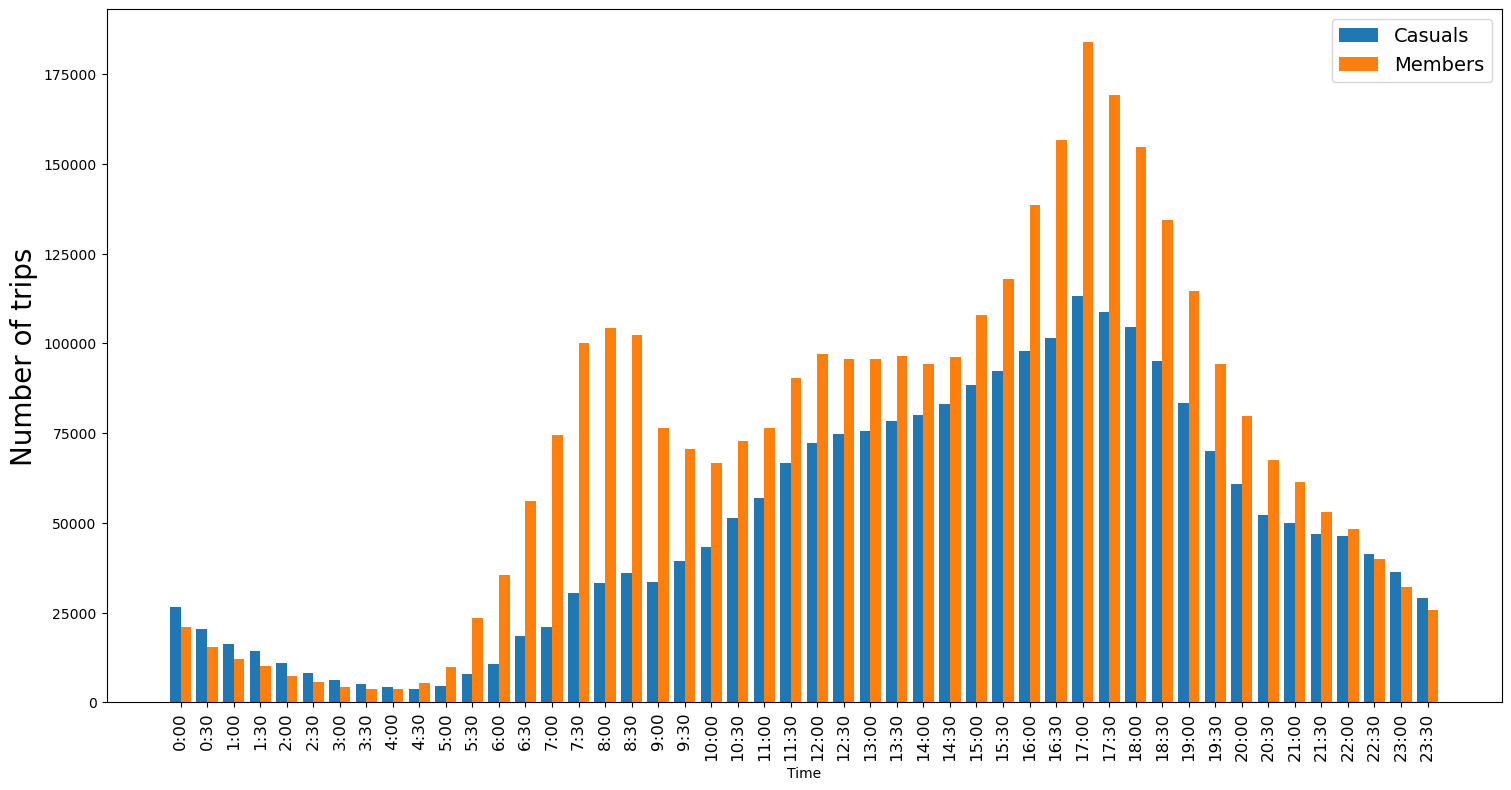

In [22]:
H=[hours for hours in range(24)]
M=['00',30]
X=[(str(h)+':'+str(m)) for h in H for m in M]
f,ax=plt.subplots(figsize=(18,9))

X_axis=np.arange(len(X))
plt.bar(X_axis - 0.2, df_casuals_hour_dist_series, 0.4, label = 'Casuals')
plt.bar(X_axis + 0.2, df_members_hour_dist_series, 0.4, label = 'Members')
plt.xticks(X_axis, X, rotation=90,fontsize=12)
plt.xlabel("Time")
plt.ylabel("Number of trips",fontsize=20)
#plt.title("Number of tri in each group")
ax.legend(fontsize=14)


### Bike trip durations

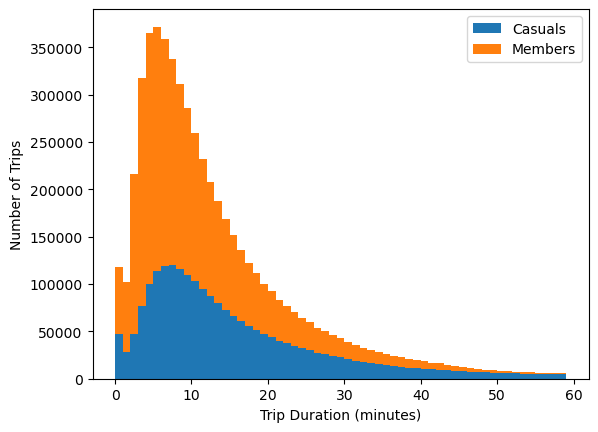

In [23]:
#define the bin edges for the histogram, from 0 to 60 with a step of 1
bins=np.arange(0,60,1)
# Create a DataFrame with the duration distributions for casual users and members
durations = pd.DataFrame({'Casuals': casuals_duration_dist, 'Members': members_duration_dist})
# Plot a stacked histogram of the durations for casual users and members
hist=durations.plot.hist(bins=bins,stacked=True)
hist.set_xlabel('Trip Duration (minutes)')
hist.set_ylabel('Number of Trips')
hist.ticklabel_format(style='plain',useOffset=False)


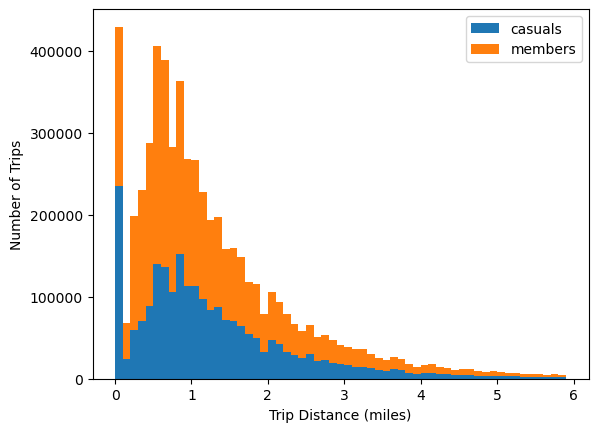

In [24]:
bins=np.arange(0, 6, 0.1)
durations = pd.DataFrame({'casuals': casuals_distance_dist, 'members': members_distance_dist})

# Plot a stacked histogram of the distances for casual users and members
hist=durations.plot.hist(bins=bins,stacked=True)

hist.set_xlabel('Trip Distance (miles)')
hist.set_ylabel('Number of Trips')

hist.ticklabel_format(style='plain',useOffset=False)

## Analysis interpretation

With no clear difference between members and casual users in terms of trip duration or distance, we are still able to focus on key distinctions in bike usage patterns:

1. **Seasonal and Weekly Preferences**: Casual users strongly prefer warmer months and weekends for the trips compared to paying members. This trend could suggest that casual users are more likely to use the service for leisure or recreational activities.
2. **Commuting Patterns**: Paying members show much stronged weekday usage as well as continued usage trough even winter months, likely indicating commuting behavior.
3. **Time-of-Day Usage**: Paying members show a typical morning commute pattern, suggesting that they use the service to travel to work or school. On the other hand, casual users do not exhibit this pattern, further supporting the idea that their usage is more likely driven by leisure or recreational activities.


## Putting the data to use

Based on my comprehensive analysis of user trips, we propose the following strategic actions:
1. **Marketing Strategy**: Intensify marketing efforts highlighting the benefits of membership, specifically targeting visitors during the summer months in Chicago. This could include special promotions or discounts for first-time users. 
2. **Partnerships**: Collaborate with local events, such as festivals or concerts, that attract tourists. This could involve offering special promotions or setting up temporary bike stations near the event locations.
3. **Flexible Subscription Models:**: Introduce a weekly subscription model catering to visitors who may not be staying for multiple months but would still benefit from a short-term subscription.

By strategically targeting these specific groups of tourists and offering flexible subscription options, I believe that Divvy Bikeshare can effectively convert more casual users into paid members, thereby increasing overall revenue and user satisfaction.


